In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import math
import itertools

import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import torch
from torch import nn

In [3]:
import geopandas as gpd

In [4]:
from functions import *
from data_preprocess import *
from models import *
from train_loops import *
from raw_data import *

# Global Variables

In [5]:
wd = 1
iterations=10001
lrs = [1e-10, 1e-7]
lrs_gravrad = [1e-7, 1e-4]
params_init = [0., 0., 0., 0., 0., 0.]
coeff = coeff5

n_distributions = 2

In [6]:
#pre-process data
list_nums = [log_misuse, log_primary, log_workforce, log_knifecrime, 
             log_gdhi]
nums = []
for num in list_nums:
    if 'City of London' in num.columns:
        nums.append(num.T.sort_index().drop(index=['City of London', 
                                           'Metropolitan Police']).T)
    else:
        nums.append(num.T.sort_index().drop(index=['Metropolitan Police']).T)

pop = torch.Tensor(pop_2019['Pi'].sort_index().drop(index=['City of London', 
                                               'Metropolitan Police']))
times_tensor = torch.Tensor(times_London['cij'].sort_index().drop(index=['City of London', 'Metropolitan Police']))
Tis = torch.Tensor([data['2019'].sum(), data['2020'].sum()])

#pre-process targets
target = torch.cat((torch.Tensor(data['2019'].sort_index()), torch.Tensor(data['2020'].sort_index())))
M_0 = len(target)

target_gravrad = torch.Tensor(data['2019'].values)
M_1 = len(target_gravrad)

#cross-validation
n_folds = 2
names_cv = [np.linspace(0, M_1-1, M_1).astype('int'), 
            np.linspace(M_1, M_0-1, M_0-M_1).astype('int')]

#loss arrays
S_retail = np.zeros((n_distributions, len(coeff), n_folds))
S_radial = np.zeros((n_distributions, n_folds))
S_gravity = np.zeros((n_distributions, n_folds))

BIC_retail = np.zeros((n_distributions, len(coeff), n_folds))
BIC_radial = np.zeros((n_distributions, n_folds))
BIC_gravity = np.zeros((n_distributions, n_folds))

#parameters

prediction_parameters_retail = np.zeros((n_distributions, n_folds, len(coeff), len(list_nums)+1))
prediction_parameters_radial = np.zeros((n_distributions, n_folds, 2))
prediction_parameters_gravity = np.zeros((n_distributions, n_folds, 2))

In [7]:
#training loops
for (d, distribution) in enumerate(['Gauss', 'Poisson']):
    print('Retail', distribution)
    for (idx_c, c) in enumerate(coeff):
        print(c)
        k = sum(c)+1
        print('Retail')
        for fold in range(n_folds):
            idx = [i for i in range(M_0) if i not in names_cv[fold]]

            params_retail, losses_retail = train_loop_retail2(target[idx], 
                                 nums, Tis, pop_London, times_tensor, 
                                 names_cv[fold], c, distribution, params_init,
                                 lr=lrs[1], iterations=iterations, wd=wd, print_=False)

            idx_min = np.where(losses_retail==min(losses_retail[-100:]))[0][-1]
            alphas = params_retail[:-1, idx_min]
            beta = params_retail[-1, idx_min]

            prediction = retail2(alphas, beta,
                               Tis, pop_London, times_tensor, nums, idx)
            
            prediction_parameters_retail[d, fold, idx_c, :-1] = alphas
            prediction_parameters_retail[d, fold, idx_c, -1] = beta
            
            if distribution == 'Poisson':
                log_L = log_poisson(target[names_cv[fold]], prediction)
            elif distribution == 'Gauss':
                log_L = log_gauss(target[names_cv[fold]], prediction)

            bic = BIC(k, log_L)
            BIC_retail[d, idx_c, fold] = bic.item()

            S = sorensen(target[names_cv[fold]], prediction)
            S_retail[d, idx_c, fold] = S.item()
            
    ##lr and target
    
    #Number of free paramters for Radial and Gravity
    k = 2
    
    print('Radial', distribution)
    for fold in range(n_folds):
        idx = [i for i in range(M_0) if i not in names_cv[fold]]

        params_radial, losses_radial = train_loop_radial(target[idx], pop, pop_London, Tis, S_ij, wd, distribution, 
                                                    names_cv[fold],
                                                    print_=False, iterations=10000, lr=lrs_gravrad[d], alpha=1, n=1)
        
        idx_min = np.where(losses_radial==min(losses_radial[-100:]))[0][-1]
        alpha = params_radial[0, idx_min]
        n = params_radial[1, idx_min];

        idx_19 = [i for i in idx if i < M_1]
        idx_20 = [i-M_1 for i in idx if i not in idx_19]
        
        prediction_19 = radial_modified(Tis[0], alpha, n, pop, pop_London, S_ij, idx_19)
        prediction_20 = radial_modified(Tis[1], alpha, n, pop, pop_London, S_ij, idx_20)
        prediction = torch.cat([prediction_19, prediction_20])

        prediction_parameters_radial[d, fold, 0] = alpha
        prediction_parameters_radial[d, fold, 1] = n
        
        if distribution == 'Poisson':
            log_L = log_poisson(target[names_cv[fold]], prediction)
        elif distribution == 'Gauss':
            log_L = log_gauss(target[names_cv[fold]], prediction)

        bic = BIC(k, log_L)
        BIC_radial[d, fold] = bic.item()
        
        S = sorensen(target[names_cv[fold]], prediction)
        S_radial[d, fold] = S.item()

    print('Gravity', distribution)
    for fold in range(n_folds):
        idx = [i for i in range(M_0) if i not in names_cv[fold]]

        params_gravity, losses_gravity = train_loop_gravity(target[idx], pop, d_Lj[:-4], Tis, wd, distribution,
                                                     names_cv[fold],
                                                    print_=False, iterations=10000, beta=0.6, gamma=1., lr=lrs_gravrad[d])
        
        idx_min = np.where(losses_gravity==min(losses_gravity[-100:]))[0][-1]
        beta = params_gravity[0, idx_min]
        gamma = params_gravity[1, idx_min]
        
        idx_19 = [i for i in idx if i < M_1]
        idx_20 = [i-M_1 for i in idx if i not in idx_19]
        
        prediction_19 = gravity_modified(beta, gamma, Tis[0], pop, d_Lj[:-4], idx_19)
        prediction_20 = gravity_modified(beta, gamma, Tis[1], pop, d_Lj[:-4], idx_20)
        prediction = torch.cat([prediction_19, prediction_20])
        
        prediction_parameters_gravity[d, fold, 0] = beta
        prediction_parameters_gravity[d, fold, 1] = gamma
        
        if distribution == 'Poisson':
            log_L = log_poisson(target[names_cv[fold]], prediction)
        elif distribution == 'Gauss':
            log_L = log_gauss(target[names_cv[fold]], prediction)

        bic = BIC(k, log_L)
        BIC_gravity[d, fold] = bic.item()

        S = sorensen(target[names_cv[fold]], prediction)
        S_gravity[d, fold] = S.item()
        
print('End')

Retail Gauss
[0, 0, 0, 0, 0]
Retail
[1, 0, 0, 0, 0]
Retail
[0, 1, 0, 0, 0]
Retail
[0, 0, 1, 0, 0]
Retail
[0, 0, 0, 1, 0]
Retail
[0, 0, 0, 0, 1]
Retail
[1, 1, 0, 0, 0]
Retail
[1, 0, 1, 0, 0]
Retail
[1, 0, 0, 1, 0]
Retail
[1, 0, 0, 0, 1]
Retail
[0, 1, 1, 0, 0]
Retail
[0, 1, 0, 1, 0]
Retail
[0, 1, 0, 0, 1]
Retail
[0, 0, 1, 1, 0]
Retail
[0, 0, 1, 0, 1]
Retail
[0, 0, 0, 1, 1]
Retail
[1, 1, 1, 0, 0]
Retail
[1, 1, 0, 1, 0]
Retail
[1, 1, 0, 0, 1]
Retail
[1, 0, 1, 1, 0]
Retail
[1, 0, 1, 0, 1]
Retail
[0, 1, 1, 1, 0]
Retail
[0, 1, 1, 0, 1]
Retail
[0, 0, 1, 1, 1]
Retail
[0, 1, 0, 1, 1]
Retail
[1, 0, 0, 1, 1]
Retail
[1, 1, 1, 1, 0]
Retail
[1, 1, 1, 0, 1]
Retail
[1, 1, 0, 1, 1]
Retail
[1, 0, 1, 1, 1]
Retail
[0, 1, 1, 1, 1]
Retail
[1, 1, 1, 1, 1]
Retail
Radial Gauss
Gravity Gauss
Retail Poisson
[0, 0, 0, 0, 0]
Retail
[1, 0, 0, 0, 0]
Retail
[0, 1, 0, 0, 0]
Retail
[0, 0, 1, 0, 0]
Retail
[0, 0, 0, 1, 0]
Retail
[0, 0, 0, 0, 1]
Retail
[1, 1, 0, 0, 0]
Retail
[1, 0, 1, 0, 0]
Retail
[1, 0, 0, 1, 0]
Retail
[1

# Analysis Sorensen

In [8]:
S = np.zeros((n_distributions*(2+len(coeff)), n_folds))
S[:2, :] = S_gravity
S[2:4, :] = S_radial
S[4:4+len(coeff), :] = S_retail[1, :, :]
S[4+len(coeff):, :] = S_retail[0, :, :]

In [11]:
Y = np.zeros((len(coeff)+4, n_folds))
Y[:2, :] = S_gravity
Y[2:4, :] = S_radial
Y[4:4+len(coeff), :] = S_retail[1, :, :]

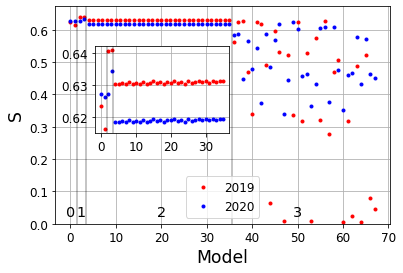

In [81]:
fig, ax = plt.subplots(1,1)

plt.plot(S[:, 1], 'r.', label='2019')
plt.plot(S[:, 0], 'b.', label='2020')

#plt.plot(S.mean(axis=1)[:], 'k+', alpha=0.4)
plt.grid()
plt.xlabel('Model', size='xx-large')
plt.ylabel('S', size='xx-large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

plt.legend(fontsize='large')

alpha=0.3
#plt.yscale('log')
plt.axvline(1.5, color='k', alpha=alpha)
plt.axvline(3.5, color='k', alpha=alpha)
plt.axvline(4+len(coeff)-0.5, color='k', alpha=alpha)

plt.ylim(ymin=0.)
plt.annotate('0', (-1, 0.025), fontsize='x-large')
plt.annotate('1', (1.3, 0.025), fontsize='x-large')
plt.annotate('2', (19, 0.025), fontsize='x-large')
plt.annotate('3', (49, 0.025), fontsize='x-large')


axins = inset_axes(ax, width="40%", height="40%", loc=2, borderpad=4)
axins.plot(S[:36, 0], 'b.')
axins.plot(S[:36, 1], 'r.')

plt.grid()

plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

#plt.ylim(ymin=0.61)
plt.axvline(1.5, color='k', alpha=alpha)
plt.axvline(3.5, color='k', alpha=alpha)


plt.savefig('Sorensen3.pdf', format='pdf', bbox_inches='tight')

25

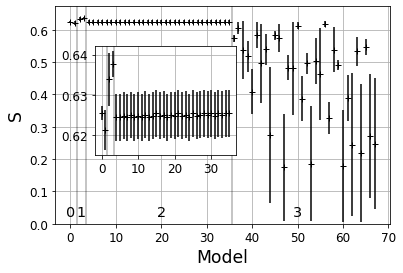

In [13]:
fig, ax = plt.subplots(1,1)

ax.errorbar(x = range(len(S.mean(axis=1))), y=S.mean(axis=1), 
            yerr=S.std(axis=1), fmt='k+')
plt.grid()
plt.xlabel('Model', size='xx-large')
plt.ylabel('S', size='xx-large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

alpha=0.3
#plt.yscale('log')
plt.axvline(1.5, color='k', alpha=alpha)
plt.axvline(3.5, color='k', alpha=alpha)
plt.axvline(4+len(coeff)-0.5, color='k', alpha=alpha)

plt.ylim(ymin=0.)
plt.annotate('0', (-1, 0.025), fontsize='x-large')
plt.annotate('1', (1.3, 0.025), fontsize='x-large')
plt.annotate('2', (19, 0.025), fontsize='x-large')
plt.annotate('3', (49, 0.025), fontsize='x-large')


axins = inset_axes(ax, width="42%", height="50%", loc=2, borderpad=4)
axins.errorbar(x = range(len(Y.mean(axis=1))), y=Y.mean(axis=1), 
               yerr=Y.std(axis=1), fmt='k+')

plt.grid()

#plt.xlabel('Model', size='large')
#plt.ylabel('S', size='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

#plt.ylim(ymin=0.61)
plt.axvline(1.5, color='k', alpha=alpha)
plt.axvline(3.5, color='k', alpha=alpha)

#plt.annotate('0', (-1.7, 0.6156), fontsize='large')
#plt.annotate('1', (1.3, 0.6156), fontsize='large')
#plt.annotate('2', (19, 0.6156), fontsize='large')

#plt.savefig('Sorensen2.pdf', format='pdf', bbox_inches='tight')

In [14]:
sorted_S = [(position, S) for (position, S) in enumerate(S.mean(axis=1))]
sorted(sorted_S, reverse=True, key=lambda tup: tup[1])[:10]

[(3, 0.6376714706420898),
 (2, 0.6339101493358612),
 (0, 0.6254221498966217),
 (30, 0.6253977119922638),
 (35, 0.6253950893878937),
 (21, 0.6253840625286102),
 (32, 0.6253813803195953),
 (25, 0.6253812909126282),
 (34, 0.6253785789012909),
 (15, 0.6253674626350403)]

In [15]:
sorted_S = [(position, S) for (position, S) in enumerate(np.concatenate([S[:, 0], S[:, 1]]))]
sorted_ = sorted(sorted_S, reverse=True, key=lambda tup: tup[1])[:10]

for i in range(10):
    s = sorted_[i][0]
    if s >= 4+len(coeff):
        s = s-(4+len(coeff))
        string_s = '{}-2'.format(s)
    else:
        string_s = '{}-1'.format(s)
    print((string_s, sorted_[i][1]))

('35-2', 0.6408362984657288)
('34-2', 0.6405370235443115)
('3-1', 0.6345066428184509)
('62-2', 0.6312422752380371)
('67-2', 0.6312422752380371)
('53-2', 0.6312333941459656)
('64-2', 0.631233274936676)
('57-2', 0.6312122941017151)
('66-2', 0.6312121748924255)
('47-2', 0.631203293800354)


# Analysis BIC

In [16]:
BICs = np.zeros((n_distributions*(2+len(coeff)), n_folds))
BICs[:2, :] = BIC_gravity
BICs[2:4, :] = BIC_radial
BICs[4:4+len(coeff), :] = BIC_retail[1, :, :]
BICs[4+len(coeff):, :] = BIC_retail[0, :, :]

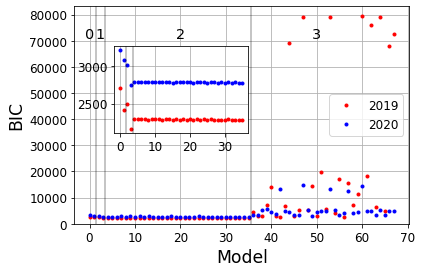

In [80]:
fig, ax = plt.subplots(1, 1)

plt.plot(BICs[:, 1], 'r.', label='2019')
plt.plot(BICs[:, 0], 'b.', label='2020')

#plt.plot(BICs.mean(axis=1)[:], 'k+', alpha=0.4)
plt.grid()
plt.xlabel('Model', size='xx-large')
plt.ylabel('BIC', size='xx-large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

plt.legend(fontsize='large')

alpha=0.3
#plt.yscale('log')
plt.axvline(1.5, color='k', alpha=alpha)
plt.axvline(3.5, color='k', alpha=alpha)
plt.axvline(4+len(coeff)-0.5, color='k', alpha=alpha)

plt.ylim(ymin=0.)
plt.annotate('0', (-1, 71000), fontsize='x-large')
plt.annotate('1', (1.3, 71000), fontsize='x-large')
plt.annotate('2', (19, 71000), fontsize='x-large')
plt.annotate('3', (49, 71000), fontsize='x-large')


axins = inset_axes(ax, width="40%", height="40%", loc=2, borderpad=4)
axins.plot(BICs[:36, 0], 'b.')
axins.plot(BICs[:36, 1], 'r.')

plt.grid()

plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

#plt.ylim(ymin=0.61)
plt.axvline(1.5, color='k', alpha=alpha)
plt.axvline(3.5, color='k', alpha=alpha)


plt.savefig('BIC3.pdf', format='pdf', bbox_inches='tight')

(2000.0, 4000.0)

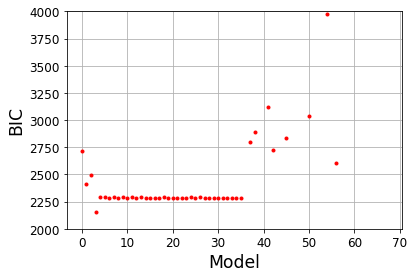

In [18]:
#plt.plot(BICs[:, 0], 'b.')
plt.plot(BICs[:, 1], 'r.')
#plt.plot(BICs.mean(axis=1)[:], 'k+', alpha=0.4)
plt.grid()
plt.xlabel('Model', size='xx-large')
plt.ylabel('BIC', size='xx-large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')
plt.ylim((2000,4000))

#plt.savefig('Sorensen.pdf', format='pdf', bbox_inches='tight')

In [19]:
Y_BIC = np.zeros((len(coeff)+4, n_folds))
Y_BIC[:2, :] = BIC_gravity
Y_BIC[2:4, :] = BIC_radial
Y_BIC[4:4+len(coeff), :] = BIC_retail[1, :, :]

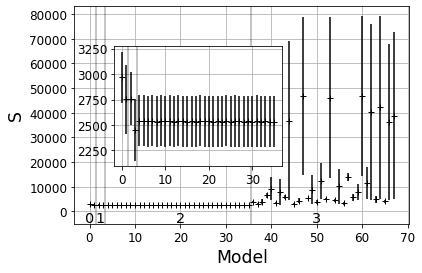

In [20]:
fig, ax = plt.subplots(1,1)

ax.errorbar(x = range(len(BICs.mean(axis=1))), y=BICs.mean(axis=1), 
            yerr=BICs.std(axis=1), fmt='k+')
plt.grid()
plt.xlabel('Model', size='xx-large')
plt.ylabel('S', size='xx-large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

alpha=0.3
#plt.yscale('log')
plt.axvline(1.5, color='k', alpha=alpha)
plt.axvline(3.5, color='k', alpha=alpha)
plt.axvline(4+len(coeff)-0.5, color='k', alpha=alpha)

plt.ylim(ymin=-5000)
plt.annotate('0', (-1, 0.025-4500), fontsize='x-large')
plt.annotate('1', (1.3, 0.025-4500), fontsize='x-large')
plt.annotate('2', (19, 0.025-4500), fontsize='x-large')
plt.annotate('3', (49, 0.025-4500), fontsize='x-large')


axins = inset_axes(ax, width="50%", height="55%", loc=2, borderpad=4)
axins.errorbar(x = range(len(Y_BIC.mean(axis=1))), y=Y_BIC.mean(axis=1), 
               yerr=Y_BIC.std(axis=1), fmt='k+')

plt.grid()

##plt.xlabel('Model', size='large')
##plt.ylabel('S', size='large')
plt.xticks(fontsize='large')
plt.yticks(fontsize='large')

##plt.ylim(ymin=0.61)
plt.axvline(1.5, color='k', alpha=alpha)
plt.axvline(3.5, color='k', alpha=alpha)

#plt.annotate('0', (-1.7, 0.6156), fontsize='large')
#plt.annotate('1', (1.3, 0.6156), fontsize='large')
#plt.annotate('2', (19, 0.6156), fontsize='large')

#plt.savefig('Sorensen2.pdf', format='pdf', bbox_inches='tight')

In [21]:
sorted_BIC = [(position, bic) for (position, bic) in enumerate(BICs.mean(axis=1))]
sorted(sorted_BIC, reverse=True, key=lambda tup: -tup[1])[:10]

[(3, 2452.675537109375),
 (21, 2530.92236328125),
 (15, 2530.9268798828125),
 (30, 2531.143310546875),
 (25, 2531.277099609375),
 (32, 2531.388671875),
 (28, 2531.5228271484375),
 (35, 2531.5286865234375),
 (34, 2531.7440185546875),
 (8, 2533.3450927734375)]

In [22]:
n = 9
sorted_BIC = [(position, bic) for (position, bic) in enumerate(np.concatenate([BICs[:, 0], BICs[:, 1]]))]
sorted_ = sorted(sorted_BIC, reverse=True, key=lambda tup: -tup[1])[:n]

corridas_BIC = []
for i in range(n):
    s = sorted_[i][0]
    if s >= 4+2*len(coeff):
        s = s-(4+2*len(coeff))
        string_s = '{}-2'.format(s)
    else:
        string_s = '{}-1'.format(s)
    corridas_BIC.append(string_s)
    print((i+1, string_s, sorted_[i][1]))
    

(1, '3-2', 2150.807861328125)
(2, '21-2', 2279.990234375)
(3, '15-2', 2280.036376953125)
(4, '30-2', 2280.209716796875)
(5, '25-2', 2280.38525390625)
(6, '32-2', 2280.455322265625)
(7, '35-2', 2280.59326171875)
(8, '28-2', 2280.630859375)
(9, '34-2', 2280.85009765625)


In [23]:
[i+2 for i in chosen_models_retail]

NameError: name 'chosen_models_retail' is not defined

- 0,1 gravity
- 2,3 radial
- 4:36 retail Poisson
- 37:68 retail Gauss

In [24]:
0.64*(1-0.066)

0.59776

In [25]:
n = 20

sorted_S = [(position, S) for (position, S) in enumerate(np.concatenate([S[:, 0], S[:, 1]]))]
sorted_ = sorted(sorted_S, reverse=True, key=lambda tup: tup[1])[:n]

#corridas_S = []
for i in range(n):
    s = sorted_[i][0]
    if s >= 4+2*len(coeff):
        s = s-(4+2*len(coeff))
        string_s = '{}-2'.format(s)
    else:
        string_s = '{}-1'.format(s)
    #corridas_S.append(string_s)
    print((i+1, string_s, sorted_[i][1]))
    

(1, '3-2', 0.6408362984657288)
(2, '2-2', 0.6405370235443115)
(3, '3-1', 0.6345066428184509)
(4, '30-2', 0.6312422752380371)
(5, '35-2', 0.6312422752380371)
(6, '21-2', 0.6312333941459656)
(7, '32-2', 0.631233274936676)
(8, '25-2', 0.6312122941017151)
(9, '34-2', 0.6312121748924255)
(10, '15-2', 0.631203293800354)
(11, '28-2', 0.6312032341957092)
(12, '23-2', 0.6308583617210388)
(13, '33-2', 0.6308583617210388)
(14, '12-2', 0.6308493614196777)
(15, '29-2', 0.6308493614196777)
(16, '17-2', 0.6308279633522034)
(17, '27-2', 0.6308279037475586)
(18, '8-2', 0.6308189630508423)
(19, '19-2', 0.6308189034461975)
(20, '20-2', 0.6306180357933044)


In [26]:
len(corridas)

NameError: name 'corridas' is not defined

In [27]:
numero = 0
for (i, string) in enumerate(corridas_S):
    if string in corridas_BIC:
        print(i+1, string)
        numero = numero + 1
print(numero, len(corridas_BIC))

NameError: name 'corridas_S' is not defined

In [28]:
models_comparison = []
for string in corridas_BIC:
    model = int(string.split('-')[0])
    if model in [0, 1]:
        print((model, 'gravity'))
        models_comparison.append(model)
    elif model in [2, 3]:
        print((model, 'radial'))
        models_comparison.append(model)
    elif model in range(4, len(coeff)+4):
        print((model, 'retail - poisson'))
        models_comparison.append(model)
    else:
        print((model-len(coeff), 'retail - gauss'))
        models_comparison.append(model-len(coeff))

(3, 'radial')
(21, 'retail - poisson')
(15, 'retail - poisson')
(30, 'retail - poisson')
(25, 'retail - poisson')
(32, 'retail - poisson')
(35, 'retail - poisson')
(28, 'retail - poisson')
(34, 'retail - poisson')


In [29]:
np.unique(np.array(models_comparison), return_counts=True)

(array([ 3, 15, 21, 25, 28, 30, 32, 34, 35]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [30]:
coeff[21-4], coeff[-3]

([1, 1, 0, 1, 0], [1, 0, 1, 1, 1])

# Predictions

In [31]:
costs = np.zeros(len(coeff)+2)
predictions = np.zeros((len(coeff)+2, len(target)))

#### Gravity
beta, gamma = prediction_parameters_gravity[1, 1, :]

prediction_19 = gravity_modified(beta, gamma, Tis[0], pop, d_Lj[:-4], [])
prediction_20 = gravity_modified(beta, gamma, Tis[1], pop, d_Lj[:-4], [])
prediction = torch.cat([prediction_19, prediction_20])

predictions[0, :] = prediction.detach().numpy()

p = (prediction-target).square().sum()/len(prediction)
costs[0] = float(p)

#### Radial
alpha, n = prediction_parameters_radial[1, 1,:]

prediction_19 = radial_modified(Tis[0], alpha, n, pop, pop_London, S_ij, [])
prediction_20 = radial_modified(Tis[1], alpha, n, pop, pop_London, S_ij, [])
prediction = torch.cat([prediction_19, prediction_20])

predictions[1, :] = prediction.detach().numpy()

p = (prediction-target).square().sum()/len(prediction)
costs[1] = float(p)

#### Retail

for i in range(len(coeff)):
    alphas = prediction_parameters_retail[1, 1, i, :-1]
    beta = prediction_parameters_retail[1, 1, i, -1]
    prediction = retail2(alphas, beta, Tis, pop_London, times_tensor, nums, [])

    predictions[2+i, :] = prediction.detach().numpy()
    
    p = (prediction-target).square().sum()/len(prediction)
    costs[2+i] = float(p)

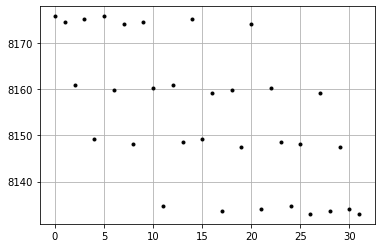

In [32]:
plt.plot(costs[2:], 'k.')
plt.grid()

In [33]:
for i in [11, 17, 21, 24, 26, 28, 30, 31]:
    print(coeff[i])

[0, 1, 0, 1, 0]
[1, 1, 0, 1, 0]
[0, 1, 1, 1, 0]
[0, 1, 0, 1, 1]
[1, 1, 1, 1, 0]
[1, 1, 0, 1, 1]
[0, 1, 1, 1, 1]
[1, 1, 1, 1, 1]


In [34]:
costs[[11+2, 17+2, 21+2, 24+2, 26+2, 28+2, 30+2, 31+2]]

array([8134.75146484, 8133.61425781, 8134.16699219, 8134.74658203,
       8133.03125   , 8133.60888672, 8134.1640625 , 8133.02539062])

In [35]:
min_cost = min(costs[[11+2, 17+2, 21+2, 24+2, 26+2, 28+2, 30+2, 31+2]])

100*(costs[[11+2, 17+2, 21+2, 24+2, 26+2, 28+2, 30+2, 31+2]]-min_cost)/min_cost

array([2.12230275e-02, 7.24044447e-03, 1.40366162e-02, 2.11629907e-02,
       7.20442236e-05, 7.17440394e-03, 1.40005941e-02, 0.00000000e+00])

In [36]:
values, indices = target[:int(len(target)/2)].sort()

In [37]:
predictions[3, indices]

array([  9.13855362,  18.86073303,  62.7492981 ,  23.57865524,
        40.13976288, 115.62090302,   7.96478558,  12.35686874,
        17.73570251,  18.3185215 ,  25.97055626,  43.8363266 ,
        49.41580582,  47.12802887,   6.47955608,  84.05821228,
        19.53626633,  58.67758942,  21.21363258,  81.21882629,
        72.36294556, 127.58195496, 247.89230347, 115.64299774,
        28.92317009, 100.51776123, 215.16387939, 231.26036072,
        67.47496033,  75.21442413, 208.97561646, 101.59740448,
       287.83639526, 126.79078674, 234.33421326, 140.12527466,
        81.30696106])

In [38]:
chosen_models_retail = [11+2, 17+2, 21+2, 24+2, 26+2, 28+2, 30+2, 31+2]

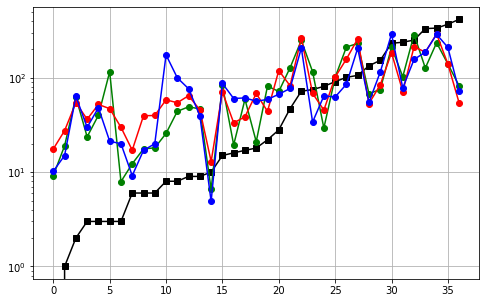

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax.plot(values, 'ks-')

ax.plot(predictions[chosen_models_retail[0], indices], 'go-')
ax.plot(predictions[0, indices], 'ro-')
ax.plot(predictions[1, indices], 'bo-')

plt.yscale('log')
plt.grid()

# Maps

In [40]:
data_geo = gpd.read_file('police_areas.geojson')

In [41]:
data_geo.columns

Index(['OBJECTID', 'PFA19CD', 'PFA19NM', 'BNG_E', 'BNG_N', 'LONG', 'LAT',
       'Shape__Area', 'Shape__Length', 'geometry'],
      dtype='object')

In [42]:
data_geo = data_geo[['PFA19NM', 'geometry']]
data_geo = data_geo.rename(columns={'PFA19NM': 'name'})
data_geo = data_geo.sort_values(by='name').reset_index(drop=True)

In [43]:
data_geo = data_geo.drop(index=[10, 14, 22, 24, 26, 31]).reset_index(drop=True)


In [44]:
df_predictions = pd.DataFrame([predictions[0, :37], 
                          predictions[0, 37:],
                          predictions[1, :37], predictions[1, 37:],
                          predictions[chosen_models_retail[0], :37],
                          predictions[chosen_models_retail[0], 37:]]).T

In [45]:
df_predictions.columns = ['Gravity 19', 'Gravity 20', 'Radial 19', 
                          'Radial 20', 'Retail 19', 'Retail 20']

In [46]:
target19 = target.detach().numpy()[:37]
target20 = target.detach().numpy()[37:]

df_target = pd.DataFrame([target19, target20]).T
df_target.columns = ['Target 19', 'Target 20']

In [47]:
df_diff = pd.DataFrame(index=df_target.index)#, columns=[0])
for year in ['19', '20']:
    for model in ['Gravity', 'Retail', 'Radial']:
        df_dummy = pd.DataFrame(df_predictions[model+' '+year]-df_target['Target '+year], 
                                columns=['Diff '+model+' '+year])
        df_diff = df_diff.join(df_dummy)

In [48]:
df = data_geo.join([df_predictions, df_target, df_diff])


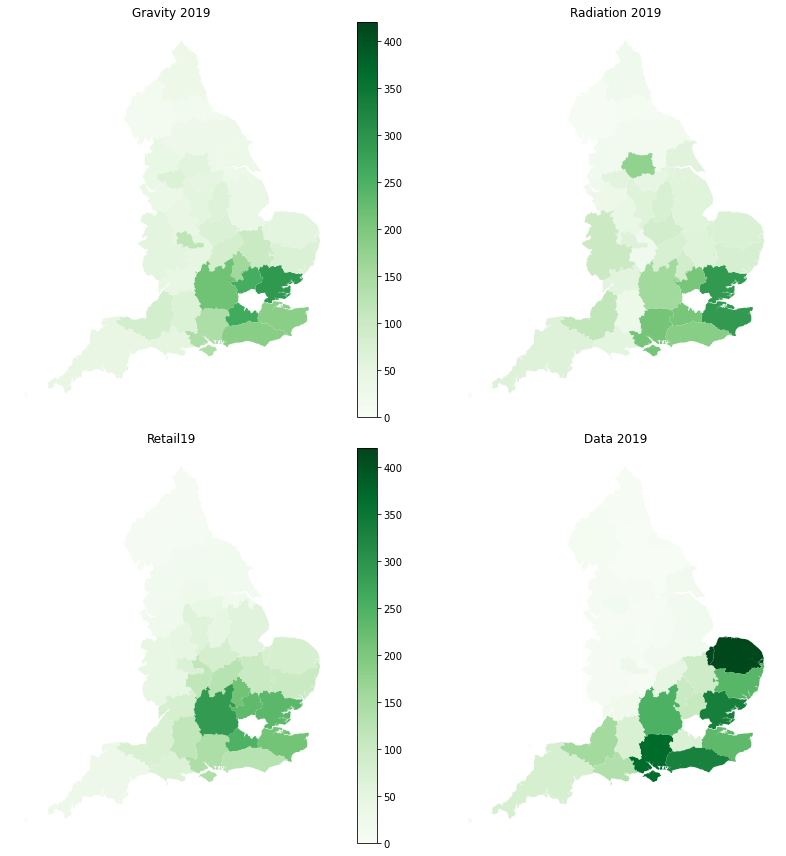

In [49]:
year='19'
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

minmax = 420 

p0 = df.plot(ax=ax[0, 0], column='Gravity '+year, legend=True, vmin=0, vmax=minmax, cmap='Greens')
p1 = df.plot(ax=ax[1, 0], column='Retail '+year, legend=True, vmin=0, vmax=minmax, cmap='Greens')
p2 = df.plot(ax=ax[0, 1], column='Radial ' +year, legend=False, vmin=0, vmax=minmax, cmap='Greens')
p3 = df.plot(ax=ax[1, 1], column='Target '+year, legend=False, vmin=0, vmax=minmax, cmap='Greens')

ax[0,0].title.set_text('Gravity 20'+year)
ax[1,0].title.set_text('Retail'+year)
ax[0,1].title.set_text('Radiation 20'+year)
ax[1,1].title.set_text('Data 20'+year)

ax[0, 0].set_axis_off()
ax[1, 0].set_axis_off()
ax[0, 1].set_axis_off()
ax[1, 1].set_axis_off()

fig.tight_layout()

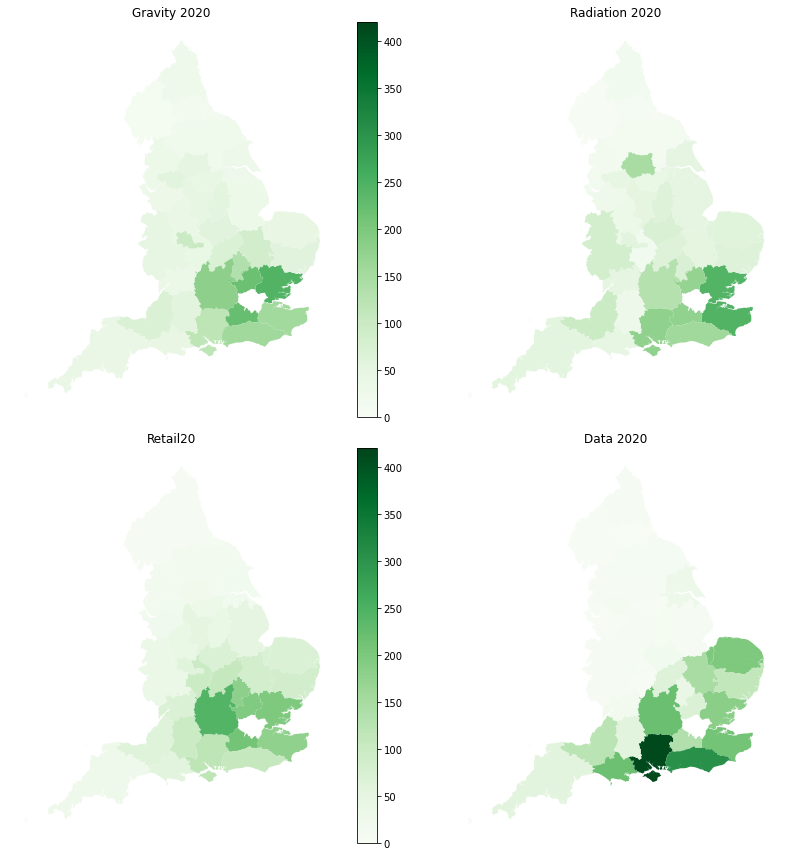

In [51]:
year='20'
fig, ax = plt.subplots(2, 2, figsize=(12, 12))

minmax = 420 

p0 = df.plot(ax=ax[0, 0], column='Gravity '+year, legend=True, vmin=0, vmax=minmax, cmap='Greens')
p1 = df.plot(ax=ax[1, 0], column='Retail '+year, legend=True, vmin=0, vmax=minmax, cmap='Greens')
p2 = df.plot(ax=ax[0, 1], column='Radial ' +year, legend=False, vmin=0, vmax=minmax, cmap='Greens')
p3 = df.plot(ax=ax[1, 1], column='Target '+year, legend=False, vmin=0, vmax=minmax, cmap='Greens')

ax[0,0].title.set_text('Gravity 20'+year)
ax[1,0].title.set_text('Retail'+year)
ax[0,1].title.set_text('Radiation 20'+year)
ax[1,1].title.set_text('Data 20'+year)

ax[0, 0].set_axis_off()
ax[1, 0].set_axis_off()
ax[0, 1].set_axis_off()
ax[1, 1].set_axis_off()

fig.tight_layout()

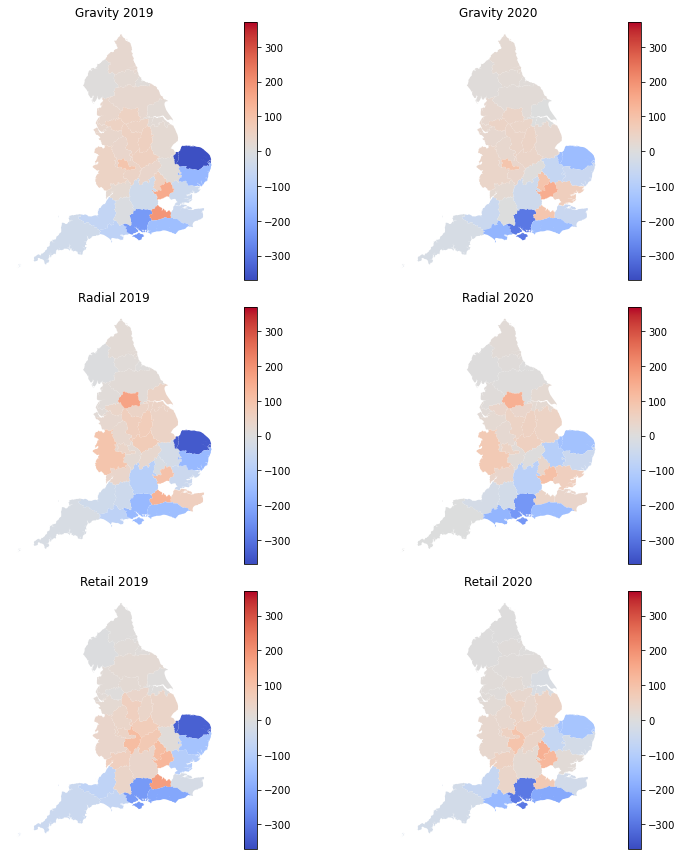

In [52]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))

minmax = 370

p0 = df.plot(ax=ax[0, 0], column='Diff Gravity 19', legend=True, vmin=-minmax, vmax=minmax, cmap='coolwarm')
p1 = df.plot(ax=ax[1, 0], column='Diff Radial 19', legend=True, vmin=-minmax, vmax=minmax, cmap='coolwarm')
p2 = df.plot(ax=ax[2, 0], column='Diff Retail 19', legend=True, vmin=-minmax, vmax=minmax, cmap='coolwarm')

p3 = df.plot(ax=ax[0, 1], column='Diff Gravity 20', legend=True, vmin=-minmax, vmax=minmax, cmap='coolwarm')
p4 = df.plot(ax=ax[1, 1], column='Diff Radial 20', legend=True, vmin=-minmax, vmax=minmax, cmap='coolwarm')
p5 = df.plot(ax=ax[2, 1], column='Diff Retail 20', legend=True, vmin=-minmax, vmax=minmax, cmap='coolwarm')

ax[0,0].title.set_text('Gravity 2019')
ax[1,0].title.set_text('Radial 2019')
ax[2,0].title.set_text('Retail 2019')
ax[0,1].title.set_text('Gravity 2020')
ax[1,1].title.set_text('Radial 2020')
ax[2,1].title.set_text('Retail 2020')

ax[0, 0].set_axis_off()
ax[1, 0].set_axis_off()
ax[2, 0].set_axis_off()
ax[0, 1].set_axis_off()
ax[1, 1].set_axis_off()
ax[2, 1].set_axis_off()

fig.tight_layout()